In [1]:
using DataFrames, StatsPlots, Query

In [2]:
using NetABM

In [3]:
using LightGraphs, Plots, GraphRecipes

In [4]:
using Distributions

In [5]:
using LaTeXStrings, Bootstrap

# Let's do a Barabasi Albert

In [6]:
copera = 0.5
adap = 1.0

1.0

In [7]:
global di = truncated(Normal(0.51,0.1),0,1)
global the_times = 100
global num_agents = 100
global adoptstep = (1,[0.2,0.1,0.05])
numnei = Int.(ceil.(exp.(range(1,stop=4,length=11))));

In [8]:
global plt = plot(
        xlabel = L"t",
        ylabel = L"<c>",
        guidefontsize = 16,
        tickfontsize = 10,
        xlims = [0, the_times],
        ylims = [0, 1]
    );

In [9]:
g = barabasi_albert(num_agents,3)

{100, 291} undirected simple Int64 graph

In [10]:
agents = [Agent(i) for i = 1:num_agents];
init_demographics!(agents;states=["S","I"],initial=[1.0,0.0],belief_dist = Uniform(0,1));
pat_0 = rand(1:nv(g))
agents[pat_0].state = "I"
set_coop_agents!(agents;p_cop=copera);
set_adapt_agents!(agents;p_cop=adap);
set_coop_effect!(agents)#,sdra=0.2,sdrt=0.2)
map(x -> assign_contacts!(g,x), agents);
global lra = Array{Float64}(undef,the_times)
global lrt = Array{Float64}(undef,the_times)
global timep = 1:the_times |> collect;

In [11]:
for i in 1:the_times
    next_state!(agents;fun=SI_attitude!,inf_prob=0.1, rec_prob=0.03, R=true);
    update_state!(agents);
    update_effect_given_distance_coop_prior!(agents,g,adoptstep[1],1,adoptstep[2],0.5);
    
    lra[i] = median([ag.coop_effect for ag in agents if (ag.attitude=="rt" && ag.adapter)])
    lrt[i] = median([ag.coop_effect for ag in agents if (ag.attitude=="ra" && ag.adapter)])
end

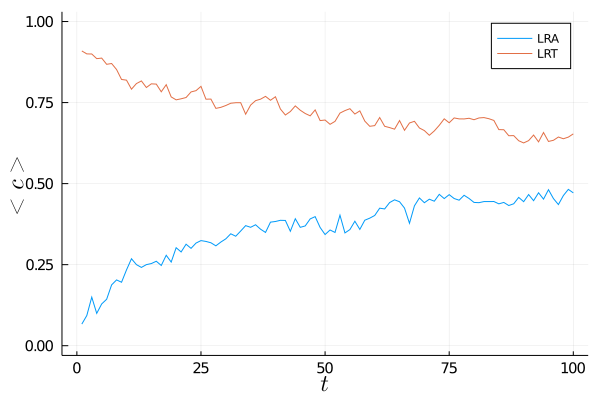

In [12]:
plot(
        x = 1:the_times,
        hcat(lra[1:the_times],lrt[1:the_times]),
        label = ["LRA" "LRT"],
        xlabel = L"t",
        ylabel = L"<c>",
        guidefontsize = 16,
        tickfontsize = 10,
        xlims = [0, the_times],
        ylims = [0, 1]
    ) 

In [13]:
n_boot = 100
cil = 0.95
copera = 0.5
adap = 1.0
global the_times = 500

500

In [14]:
global lraall = Array{Array}(undef,0)
global lrtall = Array{Array}(undef,0)

global mlra = Array{Float64}(undef,0)
global llra = Array{Float64}(undef,0)
global hlra = Array{Float64}(undef,0)

global mlrt = Array{Float64}(undef,0)
global llrt = Array{Float64}(undef,0)
global hlrt = Array{Float64}(undef,0)


for j in 1:100
    agents = [Agent(i) for i = 1:num_agents];
    init_demographics!(agents;states=["S","I"],initial=[1.0,0.0],belief_dist = Uniform(0,1));
    pat_0 = rand(1:nv(g))
    agents[pat_0].state = "I"
    set_coop_agents!(agents;p_cop=copera);
    set_adapt_agents!(agents;p_cop=adap);
    set_coop_effect!(agents;μra=1,sdra=0.2,μrt=0,sdrt=0.2)
    map(x -> assign_contacts!(g,x), agents);
    global lra = Array{Float64}(undef,the_times)
    global lrt = Array{Float64}(undef,the_times)
    global timep = 1:the_times |> collect;

    for i in 1:the_times
        next_state!(agents;fun=SI_attitude!,inf_prob=0.1, rec_prob=0.03, R=true);
        update_state!(agents);
        update_effect_given_distance_coop_prior!(agents,g,adoptstep[1],1,adoptstep[2],0.5);

        lra[i] = median([ag.coop_effect for ag in agents if (ag.attitude=="rt" && ag.adapter)])
        lrt[i] = median([ag.coop_effect for ag in agents if (ag.attitude=="ra" && ag.adapter)])
    end
    push!(lraall,lra)
    push!(lrtall,lrt)
end

In [15]:
for step in eachindex(lraall[1])
    bs1 = bootstrap(mean,getindex.(lraall,step),BasicSampling(n_boot))
    bs2 = bootstrap(std,getindex.(lraall,step),BasicSampling(n_boot))
    bci1 = confint(bs1, BasicConfInt(cil))
    bci2 = confint(bs2, BasicConfInt(cil))
#                 active[series_counter,:] = [ld, coop, step, bci1[1][1], bci1[1][2], bci1[1][3]]
    push!(mlra,bci1[1][1])
    push!(llra,bci2[1][2])
    push!(hlra,bci2[1][3])
    
    bs1 = bootstrap(mean,getindex.(lrtall,step),BasicSampling(n_boot))
    bs2 = bootstrap(std,getindex.(lrtall,step),BasicSampling(n_boot))
    bci1 = confint(bs1, BasicConfInt(cil))
    bci2 = confint(bs2, BasicConfInt(cil))
    push!(mlrt,bci1[1][1])
    push!(llrt,bci2[1][2])
    push!(hlrt,bci2[1][3])
#                 newc[series_counter,:] = [ld, coop, step, bci1[1][1], bci1[1][2], bci1[1][3]]
#                 series_counter = series_counter + 1
end


In [16]:
df = DataFrame(hcat(1:the_times,mlra,llra,hlra,mlrt,llrt,hlrt),[:time, :lra, :llra, :hlra, :lrt, :llrt, :hlrt]);

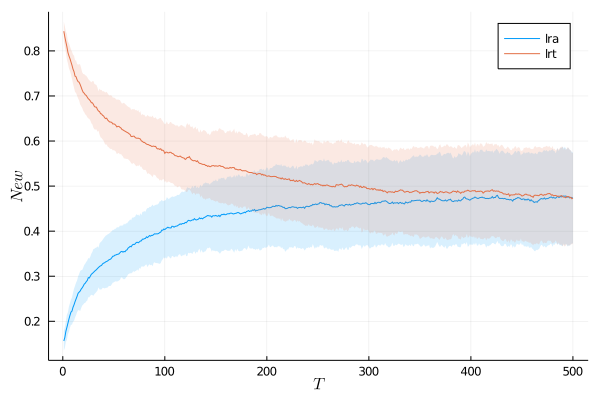

In [17]:
df |>
#     @filter(_.tlock == 5 && _.coop ∈ [0.0,0.3,0.5]) |>
    x-> stack(x,[:lra,:lrt]) |>
    @df plot(
    :time,
    :value,
    ribbon = ([:llra,:hlra]),
#     ribbon = (:llrt,:hlrt),
    fillalpha=0.15,
    group = :variable,
    xlabel = L"T",
    ylabel = L"New")

Normal with μ = 0.45

In [18]:
n_boot = 100
cil = 0.95
copera = 0.5
adap = 1.0
global the_times = 500
num_agents = 1000

1000

In [19]:
g = barabasi_albert(num_agents,3)

{1000, 2991} undirected simple Int64 graph

In [20]:
global adoptstep = (1,[0.3,0.1,0.05])

(1, [0.3, 0.1, 0.05])

In [21]:
global lraall = Array{Array}(undef,0)
global lrtall = Array{Array}(undef,0)

global mlra = Array{Float64}(undef,0)
global llra = Array{Float64}(undef,0)
global hlra = Array{Float64}(undef,0)

global mlrt = Array{Float64}(undef,0)
global llrt = Array{Float64}(undef,0)
global hlrt = Array{Float64}(undef,0)


for j in 1:100
    agents = [Agent(i) for i = 1:num_agents];
    init_demographics!(agents;states=["S","I"],initial=[1.0,0.0],belief_dist = truncated(Normal(0.45,0.1),0,1));
    pat_0 = rand(1:nv(g))
    agents[pat_0].state = "I"
    set_coop_agents!(agents;p_cop=copera);
    set_adapt_agents!(agents;p_cop=adap);
    set_coop_effect!(agents;μra=1,sdra=0.2,μrt=0,sdrt=0.2)
    map(x -> assign_contacts!(g,x), agents);
    global lra = Array{Float64}(undef,the_times)
    global lrt = Array{Float64}(undef,the_times)
    global timep = 1:the_times |> collect;

    for i in 1:the_times
        next_state!(agents;fun=SI_attitude!,inf_prob=0.1, rec_prob=0.03, R=true);
        update_state!(agents);
        update_effect_given_distance_coop_prior!(agents,g,adoptstep[1],1,adoptstep[2],0.5);

        lra[i] = median([ag.coop_effect for ag in agents if (ag.attitude=="rt" && ag.adapter)])
        lrt[i] = median([ag.coop_effect for ag in agents if (ag.attitude=="ra" && ag.adapter)])
    end
    push!(lraall,lra)
    push!(lrtall,lrt)
end

In [22]:
for step in eachindex(lraall[1])
    bs1 = bootstrap(mean,getindex.(lraall,step),BasicSampling(n_boot))
    bs2 = bootstrap(std,getindex.(lraall,step),BasicSampling(n_boot))
    bci1 = confint(bs1, BasicConfInt(cil))
    bci2 = confint(bs2, BasicConfInt(cil))
    push!(mlra,bci1[1][1])
    push!(llra,bci2[1][2])
    push!(hlra,bci2[1][3])
    
    bs1 = bootstrap(mean,getindex.(lrtall,step),BasicSampling(n_boot))
    bs2 = bootstrap(std,getindex.(lrtall,step),BasicSampling(n_boot))
    bci1 = confint(bs1, BasicConfInt(cil))
    bci2 = confint(bs2, BasicConfInt(cil))
    push!(mlrt,bci1[1][1])
    push!(llrt,bci1[1][2])
    push!(hlrt,bci1[1][3])
end


In [23]:
df = DataFrame(hcat(1:the_times,mlra,llra,hlra,mlrt,llrt,hlrt),[:time, :lra, :llra, :hlra, :lrt, :llrt, :hlrt]);

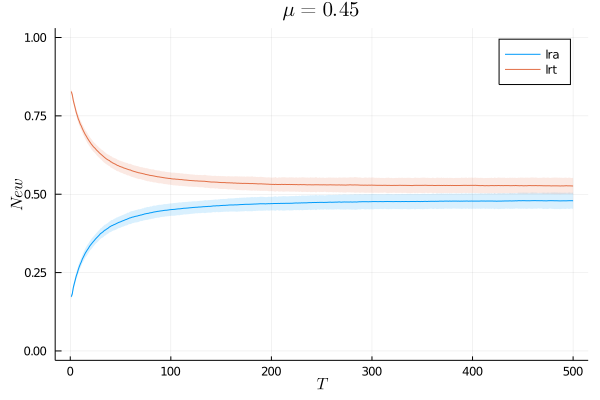

In [25]:
df |>
    x-> stack(x,[:lra,:lrt]) |>
    @df plot(
    :time,
    :value,
    ribbon = ([:llra,:hlra]),
    fillalpha=0.15,
    group = :variable,
    xlabel = L"T",
    ylabel = L"New",
    xlims = [0, the_times],
    ylims = [0, 1],
    title = L"\mu = 0.45")

# Epidemics!

In [26]:
n_boot = 100
cil = 0.95
copera = 0.5
adap = 1.0
global the_times = 500
num_agents = 1000

1000

In [145]:
g = barabasi_albert(num_agents,4)

{1000, 3984} undirected simple Int64 graph

In [146]:
global n_boot = 1000
global cil = 0.95
global coop = 0.0
global maxI = Array{Float64}(undef,0)
# global sumI = Array{Float64}(undef,0)
global sumI = []
# mus = [0, 0.25, 0.5, 0.75, 1]
mus = [0.1, 0.5, 0.9]
global reps = 100
global tsteps = 150
lenmax = reps*length(mus)
lennew = tsteps*length(mus)

global maxv = Array{Float64}(undef,lenmax,3)
global totv = Array{Float64}(undef,lenmax,3)
global active = Array{Float64}(undef,lennew,6)
global newc = Array{Float64}(undef,lennew,6)
global theRt = Array{Float64}(undef,lennew,6)
global adoptstep = (1,[0.2])

let
    counter_times = 1
    series_counter = 1
    for mu in mus
#         adoptstep[2][1] = mu
#             global meantotI = Array{Float64}(undef,0)
        global Imean = Array{Float64}(undef,0)
        global Ilow = Array{Float64}(undef,0)
        global Ihigh = Array{Float64}(undef,0)
#             global Itotall = Array{Float64}(undef,0)
        global Iall = Array{Array}(undef,0)
        global Inew = Array{Array}(undef,0)
        global R_t = Array{Array}(undef,0)
        for times in 1:reps
            agents = [Agent(i) for i = 1:num_agents];
            init_demographics!(agents;states=["S","I"],initial=[1.0,0.0],belief_dist = truncated(Normal(mu,0.2),0,1));
            pat_0 = rand(1:nv(g))
            agents[pat_0].state = "I"
            set_coop_agents!(agents;p_cop=copera);
            set_adapt_agents!(agents;p_cop=0.5); # remember, this should not be mu but adap. Change it when it's not an example
            set_coop_effect!(agents;μra=0.9,sdra=0.2,μrt=0.1,sdrt=0.2);
            map(x -> assign_contacts!(g,x), agents);

            tau = []
            num_S = []
            num_I = []
            num_R = []
            new_I = []
            Rt = []

            now_t = 0

            # fix time to do statistics
            global oldS = (num_agents - 1)/num_agents
            global oldI = 1 - oldS
            global totI = 1 - oldS
            for t in 1:tsteps
                next_state!(agents;fun=SI_attitude!,inf_prob=0.7, rec_prob=0.02, R=true);
                update_state!(agents);
                update_effect_given_distance_coop_prior!(agents,g,adoptstep[1],1,adoptstep[2],0.5);
                global populations = get_populations(agents);
                S = get(populations,"S",0)/num_agents
                I = get(populations,"I",0)/num_agents
                R = get(populations,"R",0)/num_agents

                push!(tau, now_t)
                push!(num_S, S)
                push!(num_I, I)
                push!(num_R, R)
                
                
                now_t += 1
                global newI = oldS - S
                global totI = totI + newI
                if oldI != 0
                    push!(Rt,newI/oldI)
                else
                    push!(Rt,0)
                end
                oldS = S
                push!(new_I,newI)
                oldI = newI
            end
            if maximum(Rt) > 0.1
                push!(Iall,num_I)
                push!(Inew,new_I)
                push!(R_t,Rt)
                maxv[counter_times,:] = [mu, coop, maximum(num_I)]
                totv[counter_times,:] = [mu, coop, totI]
                counter_times = counter_times + 1
            end
        end
        for step in eachindex(Iall[1])         
            bs1 = bootstrap(mean,getindex.(Iall,step),BasicSampling(n_boot))
            bs2 = bootstrap(std,getindex.(Iall,step),BasicSampling(n_boot))
            bci1 = confint(bs1, BasicConfInt(cil))
            bci2 = confint(bs2, BasicConfInt(cil))
            active[series_counter,:] = [mu, coop, step, bci1[1][1], bci2[1][2], bci2[1][3]]

            bs1 = bootstrap(mean,getindex.(Inew,step),BasicSampling(n_boot))
            bs2 = bootstrap(std,getindex.(Inew,step),BasicSampling(n_boot))
            bci1 = confint(bs1, BasicConfInt(cil))
            bci2 = confint(bs2, BasicConfInt(cil))
            newc[series_counter,:] = [mu, coop, step, bci1[1][1], bci2[1][2], bci2[1][3]]

            bs1 = bootstrap(mean,getindex.(R_t,step),BasicSampling(n_boot))
            bs2 = bootstrap(std,getindex.(R_t,step),BasicSampling(n_boot))
            bci1 = confint(bs1, BasicConfInt(cil))
            bci2 = confint(bs2, BasicConfInt(cil))
            theRt[series_counter,:] = [mu, coop, step, bci1[1][1], bci1[1][2], bci1[1][3]]
            series_counter = series_counter + 1
        end
    end
end

In [147]:
maxvdf = DataFrame(maxv,[:mu, :coop, :peak]);

In [148]:
totvdf = DataFrame(totv,[:tlock, :coop, :totInf]);

In [149]:
newcdf = DataFrame(newc,[:mu, :coop, :time, :mean, :lci, :uci]);

In [150]:
rtdf = DataFrame(theRt,[:mu, :coop, :time, :mean, :lci, :uci]);

In [151]:
serdf = DataFrame(active,[:mu, :coop, :time, :mean, :lci, :uci]);

# I'm curious about this second waves. Perhaps they're clearer with the LFR

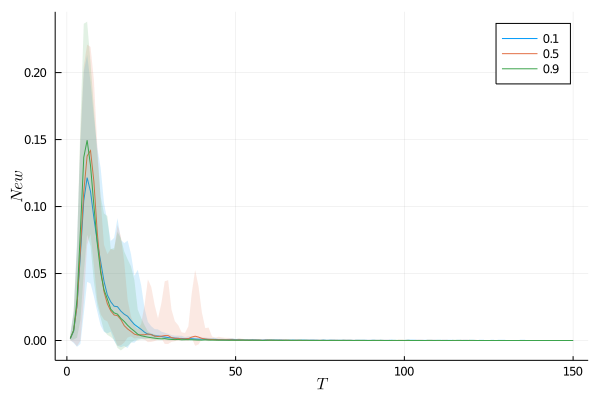

In [152]:
newcdf |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
    xlabel = L"T",
    ylabel = L"New")

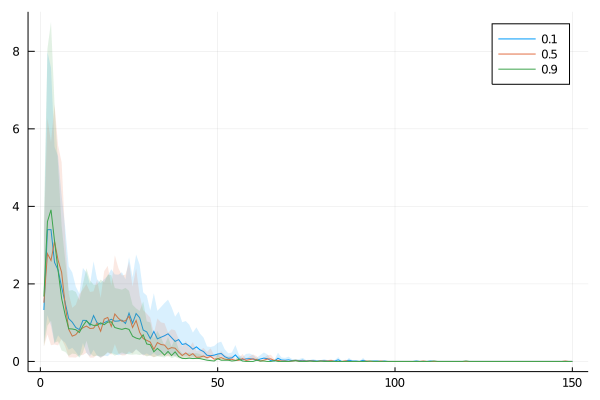

In [153]:
rtdf |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu)

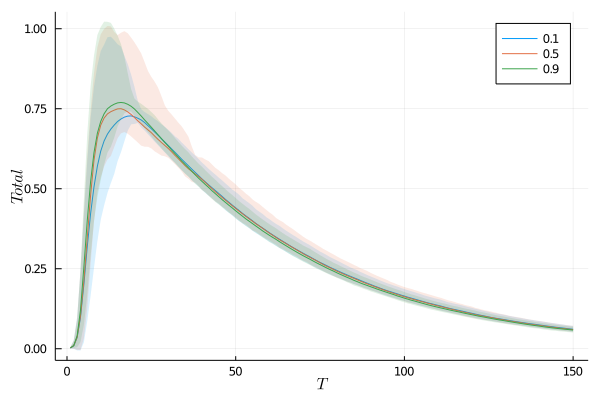

In [154]:
serdf |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
    xlabel = L"T",
    ylabel = L"Total")

# Let's make a function to replicate with multiple parameters

In [269]:
function double_contagion(g,mus,copera,adap,adoptstep;n_boot=1000,cil=0.95,reps=100,tsteps=150,inf_p=0.7,rec_p=0.02)
    maxI = Array{Float64}(undef,0)
    sumI = []
    lenmax = reps*length(mus)
    lennew = tsteps*length(mus)

    maxv = Array{Float64}(undef,lenmax,3)
    totv = Array{Float64}(undef,lenmax,3)
    active = Array{Float64}(undef,lennew,6)
    newc = Array{Float64}(undef,lennew,6)
    theRt = Array{Float64}(undef,lennew,6)

    counter_times = 1
    series_counter = 1
    for mu in mus
        global Imean = Array{Float64}(undef,0)
        global Ilow = Array{Float64}(undef,0)
        global Ihigh = Array{Float64}(undef,0)
        global Iall = Array{Array}(undef,0)
        global Inew = Array{Array}(undef,0)
        global R_t = Array{Array}(undef,0)
        for times in 1:reps
            agents = [Agent(i) for i = 1:num_agents];
            init_demographics!(agents;states=["S","I"],initial=[1.0,0.0],belief_dist = truncated(Normal(mu,0.2),0,1));
            pat_0 = rand(1:nv(g))
            agents[pat_0].state = "I"
            set_coop_agents!(agents;p_cop=copera);
            set_adapt_agents!(agents;p_cop=adap); # remember, this should not be mu but adap. Change it when it's not an example
            set_coop_effect!(agents;μra=0.9,sdra=0.2,μrt=0.1,sdrt=0.2);
            map(x -> assign_contacts!(g,x), agents);

            tau = []
            num_S = []
            num_I = []
            num_R = []
            new_I = []
            Rt = []

            now_t = 0

            global oldS = (num_agents - 1)/num_agents
            global oldI = 1 - oldS
            global totI = 1 - oldS
            infrate = 2
#             while infrate >= 1
            for t in 1:tsteps
                next_state!(agents;fun=SI_attitude!,inf_prob=inf_p, rec_prob=rec_p, R=true);
                update_state!(agents);
                update_effect_given_distance_coop_prior!(agents,g,adoptstep[1],1,adoptstep[2],0.1);
                global populations = get_populations(agents);
                S = get(populations,"S",0)/num_agents
                I = get(populations,"I",0)/num_agents
                R = get(populations,"R",0)/num_agents

                push!(tau, now_t)
                push!(num_S, S)
                push!(num_I, I)
                push!(num_R, R)


                now_t += 1
                global newI = oldS - S
                global totI = totI + newI
                if oldI != 0
                    infrate = newI/oldI
                    push!(Rt,infrate)
                else
                    push!(Rt,0)
                end
                oldS = S
                push!(new_I,newI)
                oldI = newI
            end
            if maximum(Rt) > 0.1
                push!(Iall,num_I)
                push!(Inew,new_I)
                push!(R_t,Rt)
                maxv[counter_times,:] = [mu, coop, maximum(num_I)]
                totv[counter_times,:] = [mu, coop, totI]
                counter_times = counter_times + 1
            end
        end
        for step in eachindex(Iall[1])         
            bs1 = bootstrap(mean,getindex.(Iall,step),BasicSampling(n_boot))
            bs2 = bootstrap(std,getindex.(Iall,step),BasicSampling(n_boot))
            bci1 = confint(bs1, BasicConfInt(cil))
            bci2 = confint(bs2, BasicConfInt(cil))
            active[series_counter,:] = [mu, coop, step, bci1[1][1], bci2[1][2], bci2[1][3]]

            bs1 = bootstrap(mean,getindex.(Inew,step),BasicSampling(n_boot))
            bs2 = bootstrap(std,getindex.(Inew,step),BasicSampling(n_boot))
            bci1 = confint(bs1, BasicConfInt(cil))
            bci2 = confint(bs2, BasicConfInt(cil))
            newc[series_counter,:] = [mu, coop, step, bci1[1][1], bci2[1][2], bci2[1][3]]

            bs1 = bootstrap(mean,getindex.(R_t,step),BasicSampling(n_boot))
            bs2 = bootstrap(std,getindex.(R_t,step),BasicSampling(n_boot))
            bci1 = confint(bs1, BasicConfInt(cil))
            bci2 = confint(bs2, BasicConfInt(cil))
            theRt[series_counter,:] = [mu, coop, step, bci1[1][1], bci1[1][2], bci1[1][3]]
            series_counter = series_counter + 1
        end
    end
#     maxv, totv, newc, theRt, active
    maxvdf = DataFrame(maxv,[:mu, :coop, :peak]);
    totvdf = DataFrame(totv,[:tlock, :coop, :totInf]);
    newcdf = DataFrame(newc,[:mu, :coop, :time, :mean, :lci, :uci]);
    rtdf = DataFrame(theRt,[:mu, :coop, :time, :mean, :lci, :uci]);
    serdf = DataFrame(active,[:mu, :coop, :time, :mean, :lci, :uci]);
    maxvdf, totvdf, newcdf, rtdf, serdf
end

double_contagion (generic function with 1 method)

In [279]:
mus = [0.1, 0.5, 0.9]
copera = 0.5
adap = 0.5
adoptstep = (1,[0.2])

n_boot = 100
cil = 0.95
num_agents = 1000
reps = 100
tsteps=100
inf_p=0.7
rec_p=0.02

0.02

In [280]:
g = barabasi_albert(num_agents,4)

{1000, 3984} undirected simple Int64 graph

In [281]:
maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

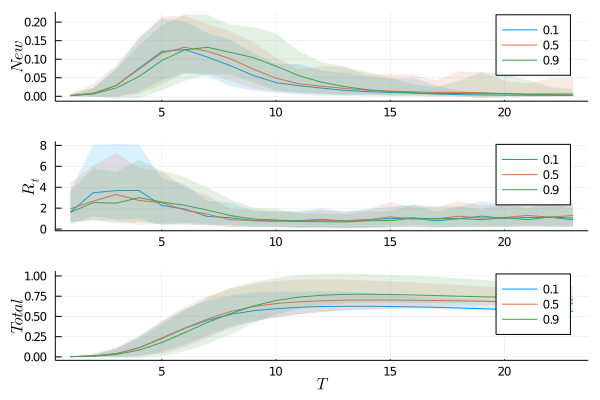

In [282]:
findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     xlabel = L"T",
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

## It works, let's try different $\langle k \rangle$

In [283]:
mus = [0.1, 0.5, 0.9]
copera = 0.5
adap = 1.0
adoptstep = (1,[0.2])

n_boot = 100
cil = 0.95
num_agents = 1000
reps = 100
tsteps=50
inf_p=0.3
rec_p=0.02

0.02

In [284]:
tsteps=50

50

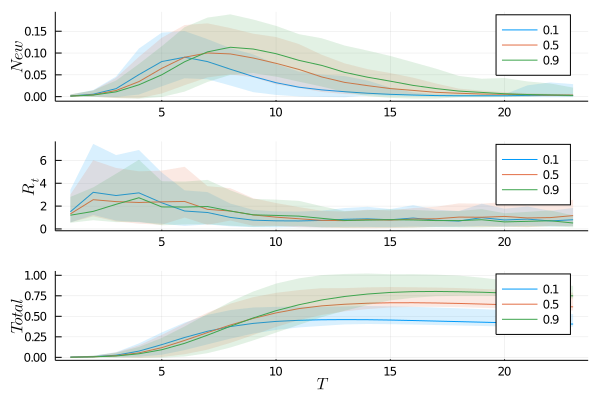

In [285]:
avk = 3
g = barabasi_albert(num_agents,avk)

maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     xlabel = L"T",
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

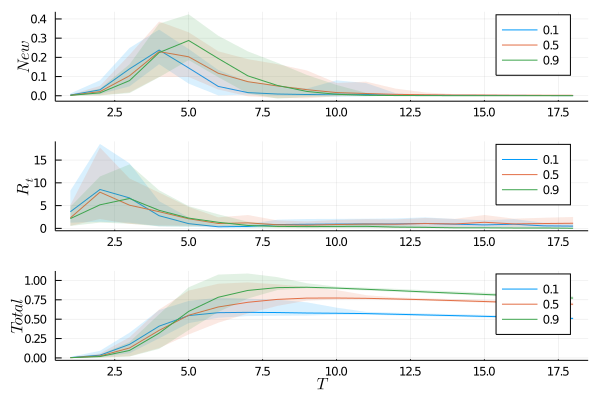

In [286]:
avk = 8
g = barabasi_albert(num_agents,avk)

maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     xlabel = L"T",
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

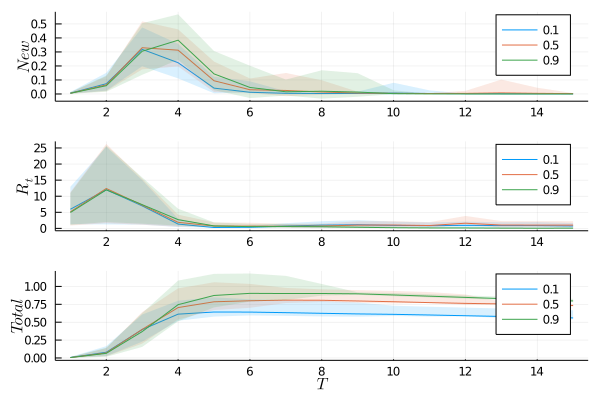

In [287]:
avk = 16
g = barabasi_albert(num_agents,avk)

maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     xlabel = L"T",
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

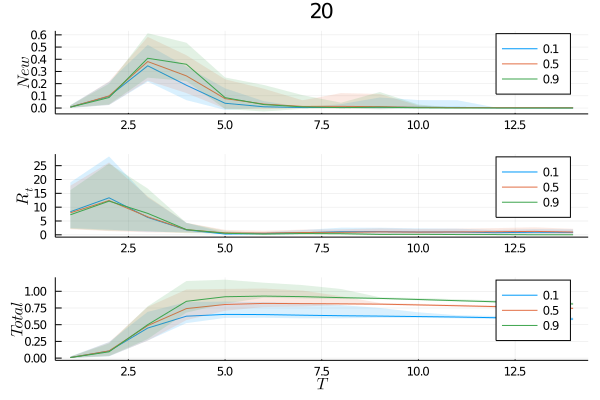

In [338]:
avk = 20
g = barabasi_albert(num_agents,avk)

maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
    title = string(avk),
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

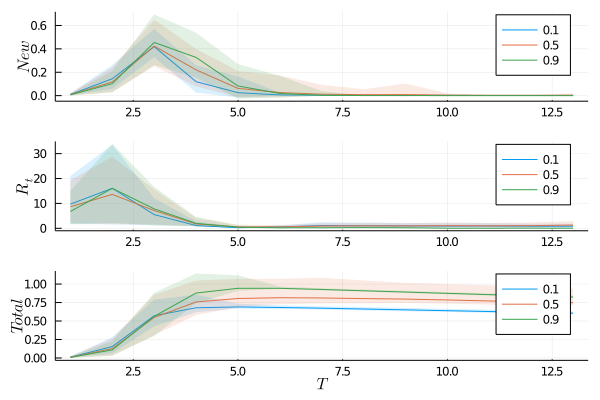

In [288]:
avk = 25
g = barabasi_albert(num_agents,avk)

maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     xlabel = L"T",
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

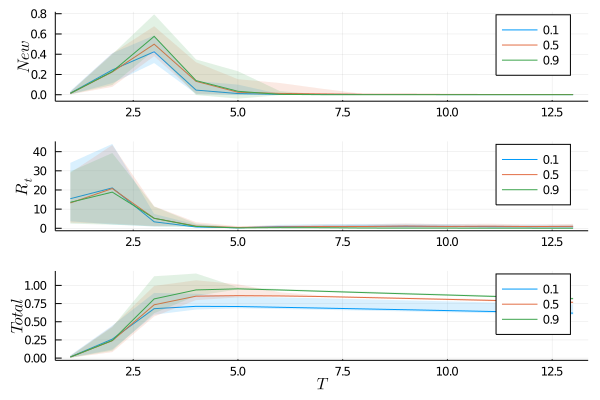

In [289]:
avk = 40
g = barabasi_albert(num_agents,avk)

maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     xlabel = L"T",
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

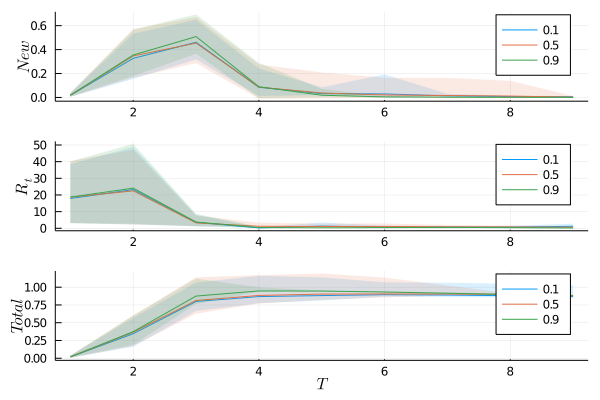

In [268]:
avk = 60
g = barabasi_albert(num_agents,avk)

maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     xlabel = L"T",
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

# What about a LFR network?

In [296]:
using DelimitedFiles
using GraphPlot

In [291]:
function lectura_uw(red)
    Nodes = union(unique(red[:,1]),unique(red[:,2]))
    g = SimpleGraph()
    last_node = Int64(length(Nodes))
    add_vertices!(g,last_node)
    for n in 1:size(red)[1]
        add_edge!(g,red[n,1],red[n,2])
        add_edge!(g,red[n,2],red[n,1])
    end
    return g, Nodes
end

lectura_uw (generic function with 1 method)

In [307]:
function get_network(;N = 100, k = 20, maxk = 40, mu = 0.1, t1 = 2, t2 = 1, minc = 10, maxc = 40, c=0.3)
        the_root = pwd()
        try
            run(`$the_root/../src/binary_networks/benchmark -N $N -k $k -maxk $maxk -mu $mu -C $c`)
        catch
            N
            #  println("OK")
        end
end

get_network (generic function with 1 method)

In [318]:
get_network(N = 1000, mu=0.1);
the_root = pwd()
the_net = readdlm(the_root*"/network.dat")
true_com = readdlm(the_root*"/community.dat")
true_com = Int64.(true_com)

g, Nodes = lectura_uw(the_net);

setting... -N 1000
setting... -k 20
setting... -maxk 40
setting... -mu 0.1
setting... -C 0.3

**************************************************************
number of nodes:	1000
average degree:	20
maximum degree:	40
exponent for the degree distribution:	2
exponent for the community size distribution:	1
mixing parameter:	0.1
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
Average clustering coefficient: 0.3
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [12 , 40]
building communities... 
connecting communities... 
trying to approach an average clustering coefficient ... 0.3
Average Clustering coefficient... 0.642813 trying to reach 0.3
recording network...


---------------------------------------------------------------------------
network of 1000 vertices and 10038 edges;	 average degree = 20.076

average mixing parameter: 0.100

In [319]:
maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)


20.0

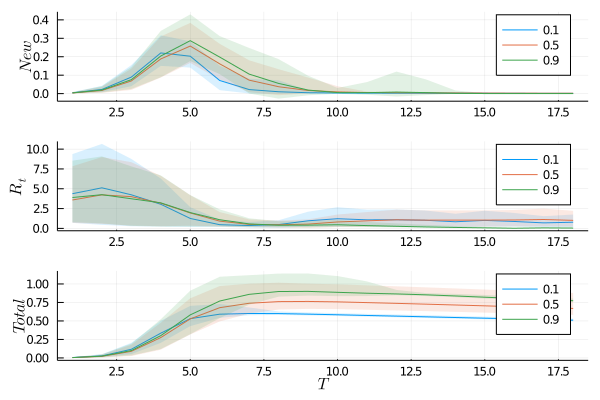

In [324]:
p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

In [325]:
get_network(N = 1000, mu=0.8);
the_root = pwd()
the_net = readdlm(the_root*"/network.dat")
true_com = readdlm(the_root*"/community.dat")
true_com = Int64.(true_com)

g, Nodes = lectura_uw(the_net);

setting... -N 1000
setting... -k 20
setting... -maxk 40
setting... -mu 0.8
setting... -C 0.3

**************************************************************
number of nodes:	1000
average degree:	20
maximum degree:	40
exponent for the degree distribution:	2
exponent for the community size distribution:	1
mixing parameter:	0.8
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
Average clustering coefficient: 0.3
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [12 , 40]
building communities... 
connecting communities... 
trying to approach an average clustering coefficient ... 0.3
Average Clustering coefficient... 0.0273646 trying to reach 0.3
Average Clustering coefficient... 0.126866 trying to reach 0.3		 expected 10 more step(s) 
Average Clustering coefficient... 0.205883 trying to reach 0.3		 expected 10 more step(s) 
Average Cluster

In [326]:
maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

16.0

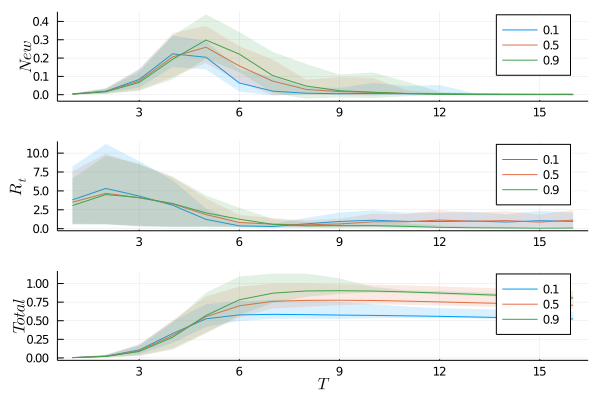

In [327]:
p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

# Changing clustering coefficient

In [335]:
get_network(N=1000, mu=0.5, c=0.1);
the_root = pwd()
the_net = readdlm(the_root*"/network.dat")
true_com = readdlm(the_root*"/community.dat")
true_com = Int64.(true_com)

g, Nodes = lectura_uw(the_net);

setting... -N 1000
setting... -k 20
setting... -maxk 40
setting... -mu 0.5
setting... -C 0.1

**************************************************************
number of nodes:	1000
average degree:	20
maximum degree:	40
exponent for the degree distribution:	2
exponent for the community size distribution:	1
mixing parameter:	0.5
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
Average clustering coefficient: 0.1
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [12 , 40]
building communities... 
connecting communities... 
trying to approach an average clustering coefficient ... 0.1
Average Clustering coefficient... 0.137437 trying to reach 0.1
recording network...


---------------------------------------------------------------------------
network of 1000 vertices and 10185 edges;	 average degree = 20.37

average mixing parameter: 0.4989

In [336]:
maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

18.0

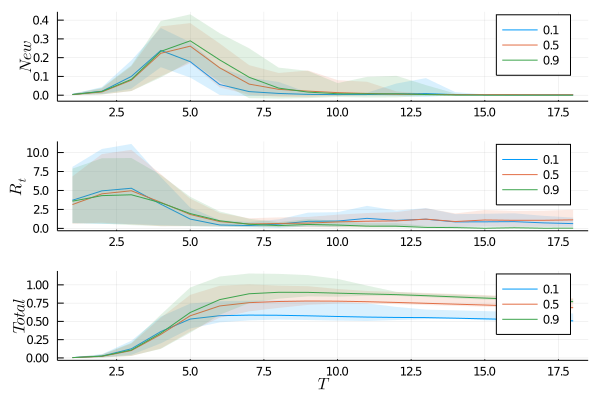

In [337]:
p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

In [331]:
get_network(N=1000, mu=0.5, c=0.8);
the_root = pwd()
the_net = readdlm(the_root*"/network.dat")
true_com = readdlm(the_root*"/community.dat")
true_com = Int64.(true_com)

g, Nodes = lectura_uw(the_net);

setting... -N 1000
setting... -k 20
setting... -maxk 40
setting... -mu 0.5
setting... -C 0.8

**************************************************************
number of nodes:	1000
average degree:	20
maximum degree:	40
exponent for the degree distribution:	2
exponent for the community size distribution:	1
mixing parameter:	0.5
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
Average clustering coefficient: 0.8
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [12 , 40]
building communities... 
connecting communities... 
trying to approach an average clustering coefficient ... 0.8
Average Clustering coefficient... 0.140372 trying to reach 0.8
Average Clustering coefficient... 0.229064 trying to reach 0.8		 expected 30 more step(s) 
Average Clustering coefficient... 0.467037 trying to reach 0.8		 expected 30 more step(s) 
Average Clusteri

In [332]:
maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

21.0

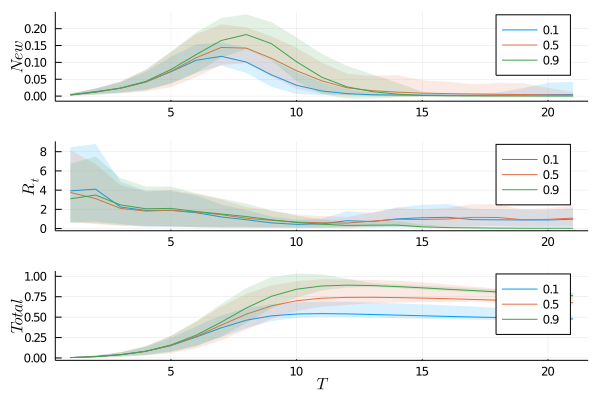

In [334]:
p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

# Low $\mu$ different clustering

In [339]:
get_network(N=1000, mu=0.1, c=0.1);
the_root = pwd()
the_net = readdlm(the_root*"/network.dat")
true_com = readdlm(the_root*"/community.dat")
true_com = Int64.(true_com)

g, Nodes = lectura_uw(the_net);

setting... -N 1000
setting... -k 20
setting... -maxk 40
setting... -mu 0.1
setting... -C 0.1

**************************************************************
number of nodes:	1000
average degree:	20
maximum degree:	40
exponent for the degree distribution:	2
exponent for the community size distribution:	1
mixing parameter:	0.1
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
Average clustering coefficient: 0.1
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [12 , 40]
building communities... 
connecting communities... 
trying to approach an average clustering coefficient ... 0.1
Average Clustering coefficient... 0.672256 trying to reach 0.1
recording network...


---------------------------------------------------------------------------
network of 1000 vertices and 10316 edges;	 average degree = 20.632

average mixing parameter: 0.099

In [340]:
maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

23.0

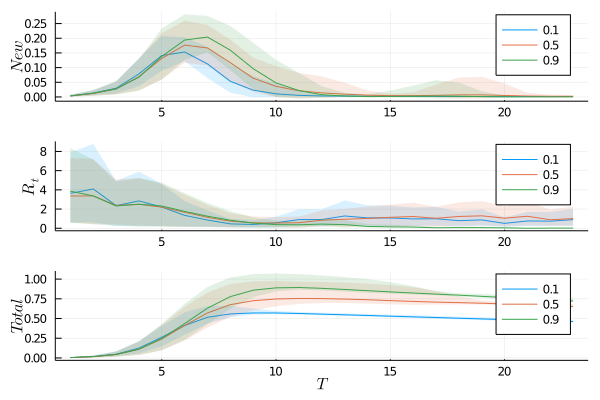

In [341]:
p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

In [342]:
get_network(N=1000, mu=0.1, c=0.8);
the_root = pwd()
the_net = readdlm(the_root*"/network.dat")
true_com = readdlm(the_root*"/community.dat")
true_com = Int64.(true_com)

g, Nodes = lectura_uw(the_net);

setting... -N 1000
setting... -k 20
setting... -maxk 40
setting... -mu 0.1
setting... -C 0.8

**************************************************************
number of nodes:	1000
average degree:	20
maximum degree:	40
exponent for the degree distribution:	2
exponent for the community size distribution:	1
mixing parameter:	0.1
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
Average clustering coefficient: 0.8
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [12 , 40]
building communities... 
connecting communities... 
trying to approach an average clustering coefficient ... 0.8
Average Clustering coefficient... 0.66312 trying to reach 0.8
Average Clustering coefficient... 0.687032 trying to reach 0.8		 expected 25 more step(s) 
Average Clustering coefficient... 0.708501 trying to reach 0.8		 expected 50 more step(s) 
Average Clusterin

In [343]:
maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

24.0

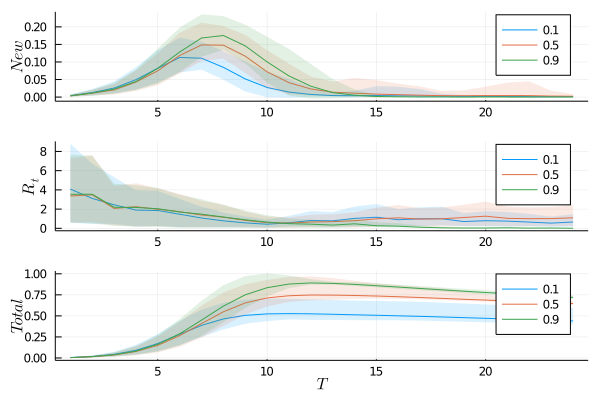

In [344]:
p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

# High $\mu$ different clustering

In [345]:
get_network(N=1000, mu=0.8, c=0.1);
the_root = pwd()
the_net = readdlm(the_root*"/network.dat")
true_com = readdlm(the_root*"/community.dat")
true_com = Int64.(true_com)

g, Nodes = lectura_uw(the_net);

setting... -N 1000
setting... -k 20
setting... -maxk 40
setting... -mu 0.8
setting... -C 0.1

**************************************************************
number of nodes:	1000
average degree:	20
maximum degree:	40
exponent for the degree distribution:	2
exponent for the community size distribution:	1
mixing parameter:	0.8
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
Average clustering coefficient: 0.1
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [12 , 40]
building communities... 
connecting communities... 
trying to approach an average clustering coefficient ... 0.1
Average Clustering coefficient... 0.026673 trying to reach 0.1
Average Clustering coefficient... 0.12597 trying to reach 0.1		 expected 1 more step(s) 
recording network...


---------------------------------------------------------------------------
network of

In [346]:
maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

20.0

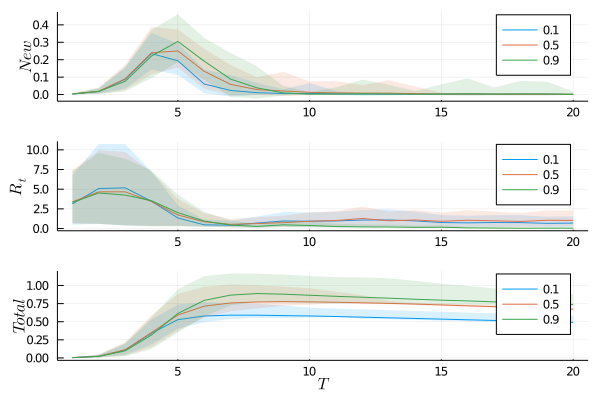

In [347]:
p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

In [348]:
get_network(N=1000, mu=0.8, c=0.8);
the_root = pwd()
the_net = readdlm(the_root*"/network.dat")
true_com = readdlm(the_root*"/community.dat")
true_com = Int64.(true_com)

g, Nodes = lectura_uw(the_net);

setting... -N 1000
setting... -k 20
setting... -maxk 40
setting... -mu 0.8
setting... -C 0.8

**************************************************************
number of nodes:	1000
average degree:	20
maximum degree:	40
exponent for the degree distribution:	2
exponent for the community size distribution:	1
mixing parameter:	0.8
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
Average clustering coefficient: 0.8
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [12 , 40]
building communities... 
connecting communities... 
trying to approach an average clustering coefficient ... 0.8
Average Clustering coefficient... 0.0270637 trying to reach 0.8
Average Clustering coefficient... 0.125142 trying to reach 0.8		 expected 35 more step(s) 
Average Clustering coefficient... 0.389827 trying to reach 0.8		 expected 50 more step(s) 
Average Cluster

In [349]:
maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

21.0

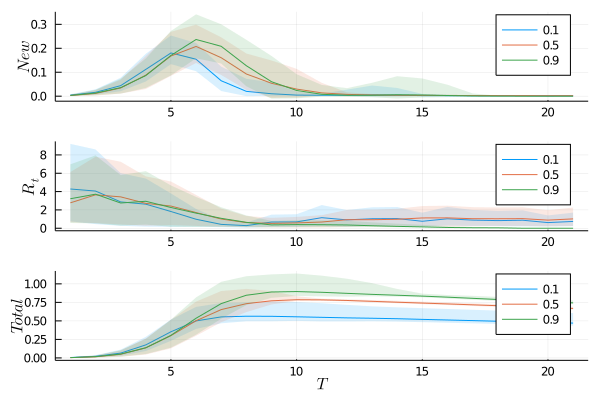

In [350]:
p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)

In [361]:
get_network(N=1000, k = 6, mu=0.1 ,c=0.1);

setting... -N 1000
setting... -k 6
setting... -maxk 40
setting... -mu 0.1
setting... -C 0.1

**************************************************************
number of nodes:	1000
average degree:	6
maximum degree:	40
exponent for the degree distribution:	2
exponent for the community size distribution:	1
mixing parameter:	0.1
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
Average clustering coefficient: 0.1
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [3 , 40]
building communities... 
connecting communities... 
trying to approach an average clustering coefficient ... 0.1
Average Clustering coefficient... -nan trying to reach 0.1
recording network...


---------------------------------------------------------------------------
network of 1000 vertices and 2655 edges;	 average degree = 5.31

average mixing parameter: 0.0965972 +/- 0

In [362]:
# get_network(N=1000, mu=0.8, c=0.8);
the_root = pwd()
the_net = readdlm(the_root*"/network.dat")
true_com = readdlm(the_root*"/community.dat")
true_com = Int64.(true_com)

g, Nodes = lectura_uw(the_net);

In [363]:
maxvdf, totvdf, newcdf, rtdf, serdf = double_contagion(g,mus,copera,adap,adoptstep;
    tsteps=tsteps);

findT = filter(x -> x.mean >= 1,rtdf)
maxT = maximum(findT.time)

35.0

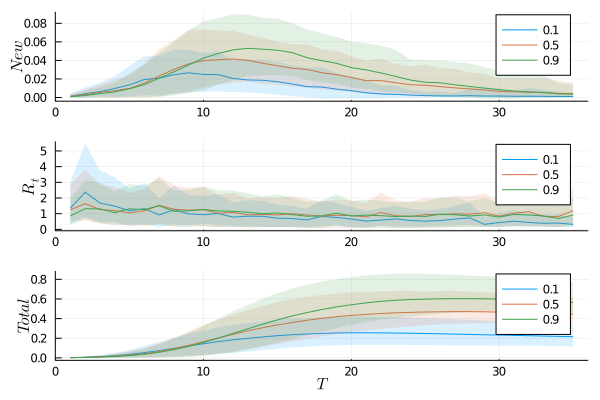

In [364]:
p1 = newcdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    ylabel = L"New")

p2 = rtdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    ylabel = L"R_t",
    group = :mu)

p3 = serdf |>
    @filter(_.time <= maxT) |>
    @df plot(
    :time,
    :mean,
    ribbon = (:lci,:uci),
    fillalpha=0.15,
    group = :mu,
#     ylims = [0,1],
    xlabel = L"T",
    ylabel = L"Total");

l = @layout [ a; b; c ]
plot(p1,p2,p3; layout=l)